# Point cloud MNIST model

In [1]:
# Please fill in your names here
NAME_STUDENT_1 = 'Chuan-Bin Huang'  # student number:1342037
NAME_STUDENT_2 = 'Xuewen Feng'  # student number:1280309

In [2]:
# environmental check
import tensorflow as tf
print("Tensorflow version:", tf.VERSION)
print("built with cuda:", tf.test.is_built_with_cuda())
# make sure gpu is used
with tf.Session() as sess:
    devices = sess.list_devices()
devices
# Intel mkl library is installed
import mkl
print(mkl.get_version_string())

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version: 1.11.0
built with cuda: True
Intel(R) Math Kernel Library Version 2018.0.2 Product Build 20180127 for Intel(R) 64 architecture applications


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img3 = mpimg.imread('img/5_1.png')
img4 = mpimg.imread('img/5_2.png')
img5 = mpimg.imread('img/5_3.png')
img6 = mpimg.imread('img/0_1.png')
img7 = mpimg.imread('img/0_2.png')
img8 = mpimg.imread('img/0_3.png')
plt.subplot(2,3,1)
plt.imshow(img3)
plt.subplot(2,3,2)
plt.imshow(img4)
plt.subplot(2,3,3)
plt.imshow(img5)
plt.subplot(2,3,4)
plt.imshow(img6)
plt.subplot(2,3,5)
plt.imshow(img7)
plt.subplot(2,3,6)
plt.imshow(img8)
plt.show()

<Figure size 640x480 with 6 Axes>

### 1. Import headers

In [4]:
# Required packages:
'''
keras
matplotlib
scikit-learn
numpy
h5py
'''
import matplotlib.pyplot as plt
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

import h5py
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# adjusted later
#batch_size = 64
#epoch = 10



Using TensorFlow backend.


In [5]:
# data path
path_data = "3d-mnist"


### 2. Load the training and testing dataset
The dataset is from Kaggle

In [6]:
#(You don't need to change this part of the code, except for possibly modifying the path to the datasets)
'''
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
'''
with h5py.File("{}/full_dataset_vectors.h5".format(path_data), 'r') as h5:
    X_train, y_train = h5["X_train"][:], h5["y_train"][:]
    X_test, y_test = h5["X_test"][:], h5["y_test"][:]

# Translate data to color
def array_to_color(array, cmap="Oranges"):
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:,:-1]

def translate(x):
    xx = np.ndarray((x.shape[0], 4096, 3))
    for i in range(x.shape[0]):
        xx[i] = array_to_color(x[i])
    del x

    return xx

y_train = to_categorical(y_train, num_classes=10)

X_train = translate(X_train).reshape(-1, 16, 16, 16, 3)  # autosize(-1) * 3D(16,16,16) * RGB(3)
X_test  = translate(X_test).reshape(-1, 16, 16, 16, 3)


### 3. Implemnet the model in the following cell

In [7]:
# Please add your model structures here
import keras
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

input_dim = (16,16,16,3)
num_classes = 10

## Iterations (adjusted for a more stable output)
#batch_size = 64
#epoch = 10
batch_size = 128
epoch = 30

## neuron layers
convo = (8, 64, 16)  # convolutional layers
dense = (512,)  # dense

## quality control
kernel_size=(3, 3, 3)
pool_size=(2, 2, 2)
activation = 'relu'  # others won't get better
dropout_rate = 0.25
padding = 'same'
# callback: reduce learning rate when the optimum is nearby
scheduler = ReduceLROnPlateau(monitor='val_acc', patience=2, factor=0.25, min_lr=1e-5, verbose=1)

## save figures for future use
suffix = "convo={}_dense={}".format(convo, dense)

def Model(input_dim, num_classes):
    """ 
    Args:
        input_dim (tuple): (16,16,16,3)
        num_classes (int): 10
    Return: model
    """    
    model = Sequential()
    ## convolutional layers
    model.add(Conv3D(convo[0], kernel_size=kernel_size, padding=padding, activation=activation, input_shape=input_dim))
    model.add(MaxPooling3D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Conv3D(convo[1], kernel_size=kernel_size, padding=padding, activation=activation))
    model.add(Conv3D(convo[2], kernel_size=kernel_size, padding=padding, activation=activation))
    #model.add(Conv3D(convo[3], kernel_size=kernel_size, padding=padding, activation=activation))
    ## dense layers
    model.add(MaxPooling3D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense[0], activation=activation))
    #model.add(Dense(dense[1], activation=activation))
    #model.add(Dropout(dropout_rate))
    # the last layer
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',   #optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])    
    return model


In [8]:
# Two helper methods, train and evaluate
def train(model):
    
    history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epoch, 
                        validation_split=0.15, verbose=1,
                        callbacks=[scheduler]) #, callbacks=[scheduler, tensorboard]
    return history

def evaluate():
    global model

    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)

    print("Accuracy = {:.4f}".format(accuracy_score(pred, y_test)))

### 4. Training the model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 16, 16, 8)     656       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 8, 8, 8)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 8, 8)        32        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 8, 8, 64)       13888     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 8, 8, 16)       27664     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 4, 4, 16)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

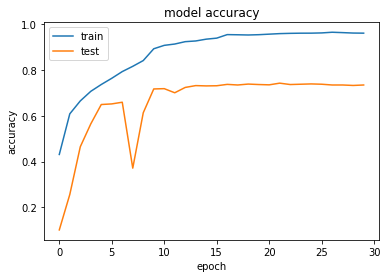

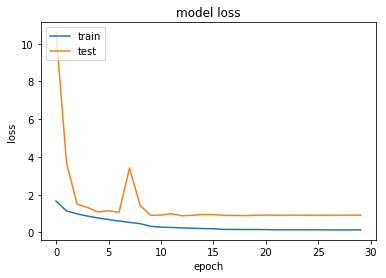

In [9]:
# (You don't need to change this part of the code)

model = Model((16,16,16,3), 10)
print('sum',model.summary())

from datetime import datetime as dt
t_start = dt.now()
history = train(model)
print("[Info] training time consumed: {:d}s".format((dt.now() - t_start).seconds))

print(history.history.keys())
evaluate()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("acc_{}.png".format(suffix))
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss_{}.png".format(suffix))
plt.show()


# Confusion Matrix

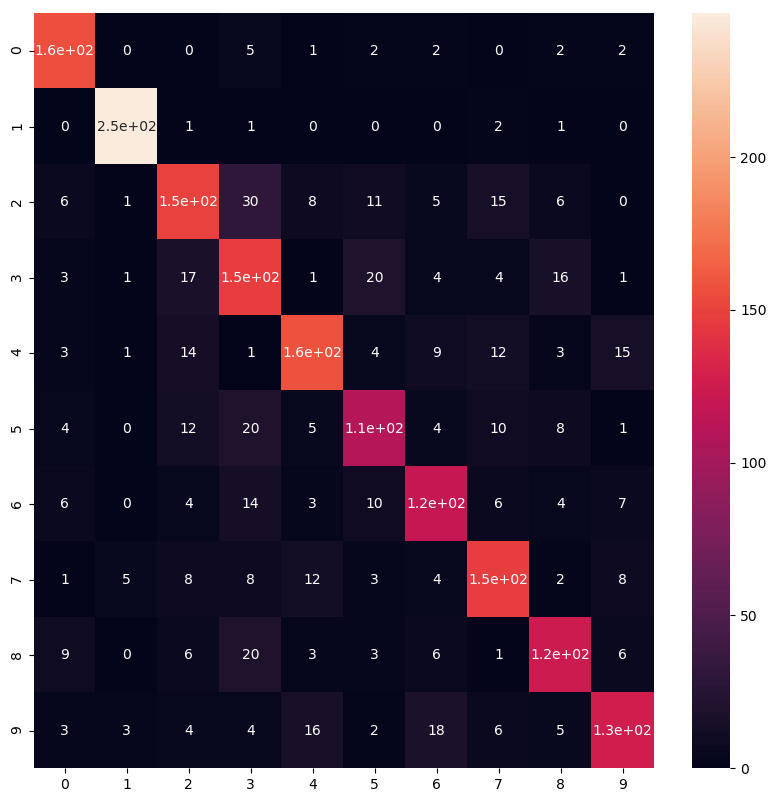

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
# Heat Map
array = confusion_matrix(y_test, pred)
cm = pd.DataFrame(array, index = range(10), columns = range(10))
plt.figure(figsize=(10, 10), dpi=100)
sns.heatmap(cm, annot=True)
plt.savefig("confusion_{}.png".format(suffix))
plt.show()